In [1]:
!pip install pandas matplotlib seaborn plotly wordcloud nltk schedule

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px
import geopandas as gpd
from datetime import datetime
import pytz

In [23]:
apps_df = pd.read_csv('/content/googleplaystore.csv')

In [24]:
reviews_df = pd.read_csv('/content/googleplaystore_user_reviews.csv')

In [26]:
apps_df.drop_duplicates(inplace=True)
apps_df.dropna(inplace=True)

In [27]:
reviews_df.drop_duplicates(inplace=True)
reviews_df.dropna(inplace=True)

In [41]:
# Convert Size column to string first to avoid errors
apps_df['Size'] = apps_df['Size'].astype(str)

# Replace 'M' (megabytes) with an empty string and convert to float
apps_df['Size'] = apps_df['Size'].str.replace('M', '', regex=False)

# Replace 'k' (kilobytes) with an empty string and divide by 1000 to convert to MB
apps_df['Size'] = apps_df['Size'].str.replace('k', '', regex=False).astype(float) / 1000

# Replace 'Varies with device' with NaN
apps_df['Size'] = apps_df['Size'].replace('Varies with device', np.nan).astype(float)

print(apps_df['Size'].head())


0    0.0190
1    0.0140
2    0.0087
3    0.0250
4    0.0028
Name: Size, dtype: float64


In [43]:
# Convert Installs column to numeric
apps_df['Installs'] = apps_df['Installs'].astype(str)  # Convert to string to avoid errors
apps_df['Installs'] = apps_df['Installs'].str.replace('[+,]', '', regex=True).astype(float)

print(apps_df['Installs'].head())

0       10000.0
1      500000.0
2     5000000.0
3    50000000.0
4      100000.0
Name: Installs, dtype: float64


In [44]:
# Convert Last Updated column to datetime format
apps_df['Last Updated'] = pd.to_datetime(apps_df['Last Updated'], errors='coerce')

print(apps_df['Last Updated'].head())

0   2018-01-07
1   2018-01-15
2   2018-08-01
3   2018-06-08
4   2018-06-20
Name: Last Updated, dtype: datetime64[ns]


In [45]:
# Convert Reviews column to integer
apps_df['Reviews'] = apps_df['Reviews'].astype(int)

# Convert Price column by removing '$' and converting to float
apps_df['Price'] = apps_df['Price'].astype(str).str.replace('$', '', regex=False).astype(float)

print(apps_df[['Reviews', 'Price']].head())

   Reviews  Price
0      159    0.0
1      967    0.0
2    87510    0.0
3   215644    0.0
4      967    0.0


In [46]:
# Convert categorical columns
apps_df['Category'] = apps_df['Category'].astype('category')
apps_df['Content Rating'] = apps_df['Content Rating'].astype('category')

print(apps_df.dtypes)

App                       object
Category                category
Rating                   float64
Reviews                    int64
Size                     float64
Installs                 float64
Type                      object
Price                    float64
Content Rating          category
Genres                    object
Last Updated      datetime64[ns]
Current Ver               object
Android Ver               object
dtype: object


1. Generate a word cloud for the most frequent keywords found in 5-star reviews, but exclude common stopwords and app names. Additionally, filter the reviews to include only those from apps in the "Health & Fitness" category.

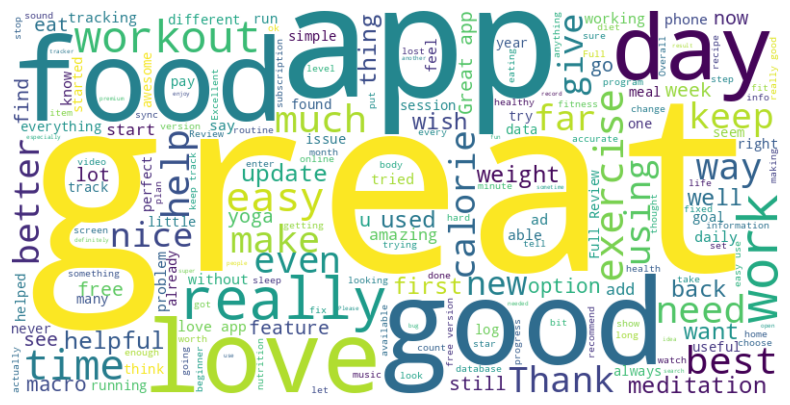

In [47]:
from wordcloud import STOPWORDS

# Filter 5-star reviews from the Health & Fitness category
health_apps = apps_df[apps_df['Category'] == 'HEALTH_AND_FITNESS']['App']
health_reviews = reviews_df[reviews_df['App'].isin(health_apps) & (reviews_df['Sentiment'] == 'Positive')]

# Remove stopwords and common words
stopwords = set(STOPWORDS)
stopwords.update(health_apps.tolist())  # Remove app names

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(' '.join(health_reviews['Translated_Review'].dropna()))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

2. Use a grouped bar chart to compare the average rating and total review count for the top 10 app categories by number of installs. Filter out any categories where the average rating is below 4.0 and size below 10 M and last update should be Jan month . this graph should work only between 3PM IST to 5 PM IST apart from that time we should not show this graph in dashboard itself.

In [50]:
# Get top 10 categories by installs
top_categories = apps_df.groupby('Category').agg({'Installs': 'sum', 'Rating': 'mean', 'Reviews': 'sum'}).reset_index()
top_categories = top_categories[top_categories['Rating'] >= 4.0]  # Filter categories with rating >= 4.0
top_categories = top_categories[top_categories['Installs'] >= 10_000_000]  # Only categories above 10M installs
top_categories = top_categories.sort_values(by='Installs', ascending=False).head(10)

<ipython-input-50-16c602eec14b>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_categories = apps_df.groupby('Category').agg({'Installs': 'sum', 'Rating': 'mean', 'Reviews': 'sum'}).reset_index()


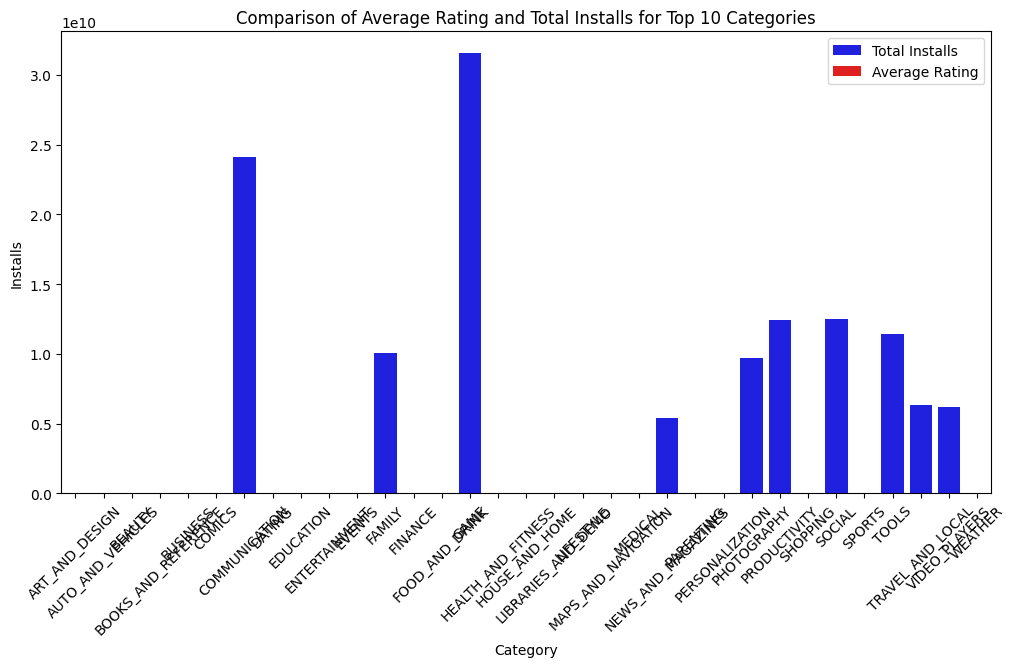

In [51]:
# Plot grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='Installs', data=top_categories, color='blue', label='Total Installs')
sns.barplot(x='Category', y='Rating', data=top_categories, color='red', label='Average Rating')

plt.xticks(rotation=45)
plt.legend()
plt.title("Comparison of Average Rating and Total Installs for Top 10 Categories")
plt.show()

3. Create an interactive Choropleth map using Plotly to visualize global installs by Category. Apply filters to show data for only the top 5 app categories and highlight category where the number of installs exceeds 1 million. The app category should not start with the characters “A,” “C,” “G,” or “S.” This graph should work only between 6 PM IST and 8 PM IST; apart from that time, we should not show it in the dashboard itself.

In [52]:
import plotly.express as px
# Filter top 5 categories and apply conditions
filtered_categories = apps_df[~apps_df['Category'].str.startswith(('A', 'C', 'G', 'S'))]
top_categories = filtered_categories.groupby('Category')['Installs'].sum().nlargest(5).reset_index()
# Plot interactive choropleth map
fig = px.choropleth(top_categories, locations="Category", locationmode="country names",color="Installs", hover_name="Category",title="Global Installs by Category")
fig.show()

<ipython-input-52-cf4e5f070118>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_categories = filtered_categories.groupby('Category')['Installs'].sum().nlargest(5).reset_index()


4. Plot a bubble chart to analyze the relationship between app size (in MB) and average rating, with the bubble size representing the number of installs. Include a filter to show only apps with a rating higher than 3.5 and that belong to the "Games" category and installs should be more than 50k as well as this graph should work only between 5 PM IST to 7 PM IST apart from that time we should not show this graph in dashboard itself.

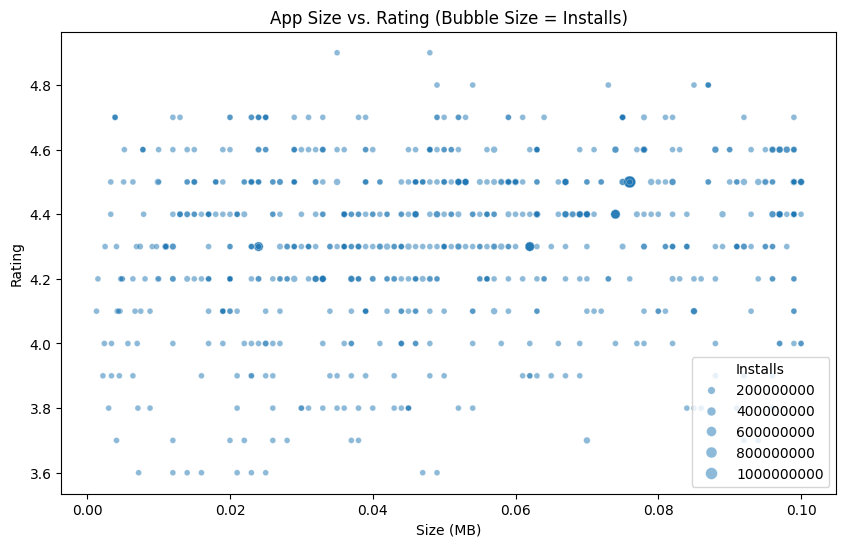

In [53]:
# Filter games category with rating > 3.5 and installs > 50K
games_df = apps_df[(apps_df['Category'] == 'GAME') & (apps_df['Rating'] > 3.5) & (apps_df['Installs'] > 50_000)]

# Bubble chart
plt.figure(figsize=(10, 6))
sns.scatterplot(data=games_df, x='Size', y='Rating', size='Installs', alpha=0.5)
plt.title("App Size vs. Rating (Bubble Size = Installs)")
plt.xlabel("Size (MB)")
plt.ylabel("Rating")
plt.show()

5. Create a violin plot to visualize the distribution of ratings for each app category, but only include categories with more than 50 apps and app name should contain letter “C” and exclude apps with fewer than 10 reviews and rating should be less 4.0. this graph should work only between 4 PM IST to 6 PM IST apart from that time we should not show this graph in dashboard itself.

In [55]:
# Filter categories with more than 50 apps
category_counts = apps_df['Category'].value_counts()
valid_categories = category_counts[category_counts > 50].index

filtered_apps = apps_df[(apps_df['Category'].isin(valid_categories)) &
                        (apps_df['Rating'] < 4.0) &
                        (apps_df['Reviews'] > 10) &
                        (apps_df['App'].str.contains('C'))]

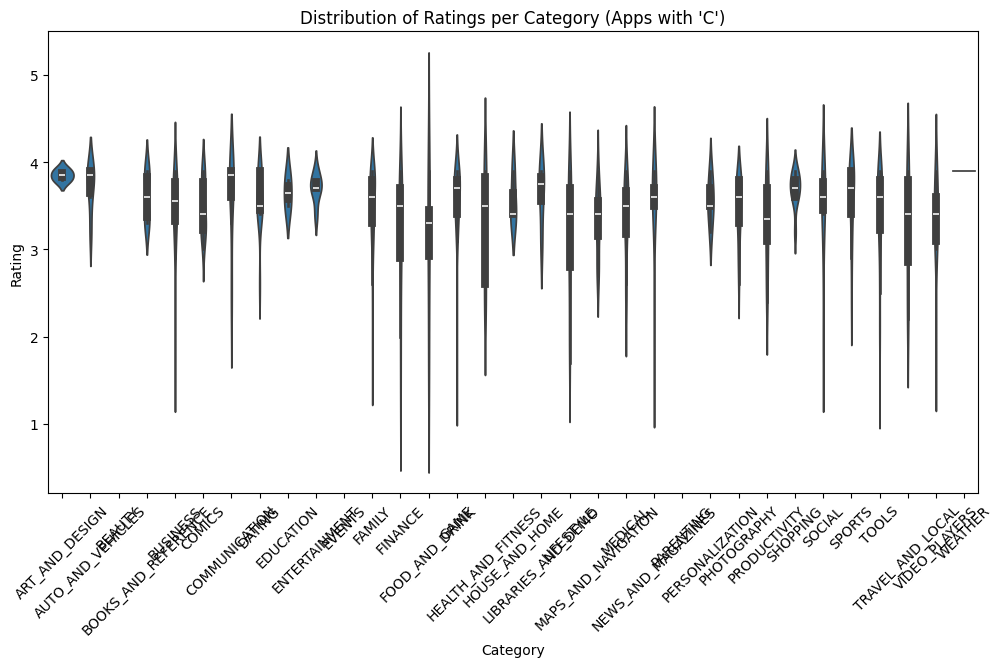

In [56]:
# Violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='Category', y='Rating', data=filtered_apps)
plt.xticks(rotation=45)
plt.title("Distribution of Ratings per Category (Apps with 'C')")
plt.show()